# Data Merge

#### 0. Load Data
Load raw data and required packages.

In [790]:
import pandas as pd
import numpy as np
import mpu
import json
import re  
import geopandas as gpd
import folium
# import pygeos
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

house = pd.read_csv('../data/house_combined.csv')
bus = pd.read_csv('../data/bus_stops_file.csv')
train = pd.read_csv('../data/train_stops_file.csv')
tram = pd.read_csv('../data/tram_stops_file.csv')
vline = pd.read_csv('../data/vline_stops_file.csv')
school = pd.read_csv('../data/school.csv',sep=",", encoding='cp1252')
hospital = pd.read_csv('../data/hospital_csv',sep=",", encoding='cp1252')
sc = pd.read_csv('../data/shopping_with_postcode.csv')
data_2019 = pd.read_csv('../data/2019_data.csv',sep=",", encoding='cp1252')
data_2020 = pd.read_csv('../data/2020_data.csv',sep=",", encoding='cp1252')
data_2021 = pd.read_csv('../data/2021_data.csv',sep=",", encoding='cp1252')
data_2022 = pd.read_csv('../data/2022_data.csv',sep=",", encoding='cp1252')
data_2022 = pd.read_csv('../data/2022_data.csv',sep=",", encoding='cp1252')
combine = pd.read_csv('../data/attribute_conbined.csv',sep=",", encoding='cp1252')
offence = pd.read_excel('../data/recorded offences.xlsx')
criminal = pd.read_excel('../data/criminal incidents2022-2013.xlsx')

In [795]:
house = house.drop('Unnamed: 0', axis = 1)

In [796]:
house

,propertyTypes,objective,addressParts,advertiserIdentifiers,bathrooms,bedrooms,carspaces,dateUpdated,dateListed,geoLocation,priceDetails,landAreaSqm,dateAvailable,postcode,surburb,year,month,price,bond,rent,state
0,['apartmentUnitFlat'],rent,"{'stateAbbreviation': 'vic', 'displayType': 'f...","{'advertiserType': 'agency', 'advertiserId': 2...",1.0,1.0,0.0,2019-01-09T00:23:18.123Z,2016-02-16T04:33:49Z,"{'latitude': -37.8341628, 'longitude': 144.960...","{'canDisplayPrice': False, 'displayPrice': '$3...",NaN,NaN,3205,south melbourne,2019,1,$360.00 per week,NaN,360.0,vic
1,['apartmentUnitFlat'],rent,"{'stateAbbreviation': 'vic', 'displayType': 'f...","{'advertiserType': 'agency', 'advertiserId': 2...",2.0,4.0,4.0,2019-01-03T22:51:13.063Z,2018-10-02T00:00:38Z,"{'latitude': -37.8443239, 'longitude': 144.943...","{'canDisplayPrice': False, 'displayPrice': '$1...",NaN,NaN,3207,port melbourne,2019,1,$1800.00 per week,NaN,1800.0,vic
2,['apartmentUnitFlat'],rent,"{'stateAbbreviation': 'vic', 'displayType': 'f...","{'advertiserType': 'agency', 'advertiserId': 2...",2.0,2.0,1.0,2019-01-10T17:10:35.493Z,2018-10-05T04:57:13Z,"{'latitude': -37.8430561, 'longitude': 144.94026}","{'canDisplayPrice': False, 'displayPrice': '$5...",NaN,NaN,3207,port melbourne,2019,1,$550.00 per week,NaN,550.0,vic
3,['house'],rent,"{'stateAbbreviation': 'vic', 'displayType': 'f...","{'advertiserType': 'agency', 'advertiserId': 2...",2.0,3.0,0.0,2019-01-22T00:20:53.707Z,2018-10-05T07:07:14Z,"{'latitude': -37.846166, 'longitude': 144.957026}","{'canDisplayPrice': False, 'displayPrice': '$9...",NaN,NaN,3206,albert park,2019,1,$975.00 per week,NaN,975.0,vic
4,['apartmentUnitFlat'],rent,"{'stateAbbreviation': 'vic', 'displayType': 'f...","{'advertiserType': 'agency', 'advertiserId': 2...",1.0,2.0,1.0,2019-01-17T17:10:07.873Z,2018-10-17T01:02:26Z,"{'latitude': -37.8408338, 'longitude': 144.939...","{'canDisplayPrice': False, 'displayPrice': '$5...",NaN,NaN,3207,port melbourne,2019,1,$500.00 per week,NaN,500.0,vic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114980,['house'],rent,"{'stateAbbreviation': 'vic', 'displayType': 'f...","{'advertiserType': 'agency', 'advertiserId': 2...",1.0,2.0,1.0,2021-03-25T22:25:48.957Z,2021-03-12T06:10:56Z,"{'latitude': -36.1394497, 'longitude': 146.882...","{'canDisplayPrice': False, 'displayPrice': '$2...",NaN,2021-04-05,3690,wodonga,2021,3,$215 per week,NaN,215.0,vic
114981,['house'],rent,"{'stateAbbreviation': 'vic', 'displayType': 'f...","{'advertiserType': 'agency', 'advertiserId': 2...",2.0,4.0,2.0,2021-03-31T00:18:22.6Z,2021-03-18T00:21:42Z,"{'latitude': -36.1787142, 'longitude': 146.940...","{'canDisplayPrice': False, 'displayPrice': '$4...",NaN,2021-04-22,3691,baranduda,2021,3,$465 per week,NaN,465.0,vic
114982,['townhouse'],rent,"{'stateAbbreviation': 'vic', 'displayType': 'f...","{'advertiserType': 'agency', 'advertiserId': 2...",1.0,2.0,1.0,2021-03-30T22:40:44.093Z,2021-03-23T06:13:04Z,"{'latitude': -36.1298786, 'longitude': 146.885...","{'canDisplayPrice': False, 'displayPrice': '$3...",NaN,2021-03-31,3690,wodonga,2021,3,$320 per week,NaN,320.0,vic
114983,['house'],rent,"{'stateAbbreviation': 'vic', 'displayType': 'f...","{'advertiserType': 'agency', 'advertiserId': 2...",2.0,3.0,2.0,2021-04-08T22:10:17.477Z,2021-03-26T00:07:22Z,"{'latitude': -36.1398519, 'longitude': 146.887...","{'canDisplayPrice': False, 'displayPrice': '$3...",448.0,2021-05-05,3690,wodonga,2021,4,$360 per week,NaN,360.0,vic


In [793]:
distance_to_melbourne = pd.read_csv('../data/distance_to_melbourne_central').drop('Unnamed: 0', axis = 1)
distance_to_melbourne

,distance_to_melbourne
0,2990.7
1,5175.7
2,5034.4
3,4758.3
4,4845.9
...,...
114980,315032.8
114981,322289.7
114982,312324.4
114983,314924.0


In [797]:
house['distance_to_melbourne'] = distance_to_melbourne['distance_to_melbourne']

In [798]:
house

,propertyTypes,objective,addressParts,advertiserIdentifiers,bathrooms,bedrooms,carspaces,dateUpdated,dateListed,geoLocation,priceDetails,landAreaSqm,dateAvailable,postcode,surburb,year,month,price,bond,rent,state,distance_to_melbourne
0,['apartmentUnitFlat'],rent,"{'stateAbbreviation': 'vic', 'displayType': 'f...","{'advertiserType': 'agency', 'advertiserId': 2...",1.0,1.0,0.0,2019-01-09T00:23:18.123Z,2016-02-16T04:33:49Z,"{'latitude': -37.8341628, 'longitude': 144.960...","{'canDisplayPrice': False, 'displayPrice': '$3...",NaN,NaN,3205,south melbourne,2019,1,$360.00 per week,NaN,360.0,vic,2990.7
1,['apartmentUnitFlat'],rent,"{'stateAbbreviation': 'vic', 'displayType': 'f...","{'advertiserType': 'agency', 'advertiserId': 2...",2.0,4.0,4.0,2019-01-03T22:51:13.063Z,2018-10-02T00:00:38Z,"{'latitude': -37.8443239, 'longitude': 144.943...","{'canDisplayPrice': False, 'displayPrice': '$1...",NaN,NaN,3207,port melbourne,2019,1,$1800.00 per week,NaN,1800.0,vic,5175.7
2,['apartmentUnitFlat'],rent,"{'stateAbbreviation': 'vic', 'displayType': 'f...","{'advertiserType': 'agency', 'advertiserId': 2...",2.0,2.0,1.0,2019-01-10T17:10:35.493Z,2018-10-05T04:57:13Z,"{'latitude': -37.8430561, 'longitude': 144.94026}","{'canDisplayPrice': False, 'displayPrice': '$5...",NaN,NaN,3207,port melbourne,2019,1,$550.00 per week,NaN,550.0,vic,5034.4
3,['house'],rent,"{'stateAbbreviation': 'vic', 'displayType': 'f...","{'advertiserType': 'agency', 'advertiserId': 2...",2.0,3.0,0.0,2019-01-22T00:20:53.707Z,2018-10-05T07:07:14Z,"{'latitude': -37.846166, 'longitude': 144.957026}","{'canDisplayPrice': False, 'displayPrice': '$9...",NaN,NaN,3206,albert park,2019,1,$975.00 per week,NaN,975.0,vic,4758.3
4,['apartmentUnitFlat'],rent,"{'stateAbbreviation': 'vic', 'displayType': 'f...","{'advertiserType': 'agency', 'advertiserId': 2...",1.0,2.0,1.0,2019-01-17T17:10:07.873Z,2018-10-17T01:02:26Z,"{'latitude': -37.8408338, 'longitude': 144.939...","{'canDisplayPrice': False, 'displayPrice': '$5...",NaN,NaN,3207,port melbourne,2019,1,$500.00 per week,NaN,500.0,vic,4845.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114980,['house'],rent,"{'stateAbbreviation': 'vic', 'displayType': 'f...","{'advertiserType': 'agency', 'advertiserId': 2...",1.0,2.0,1.0,2021-03-25T22:25:48.957Z,2021-03-12T06:10:56Z,"{'latitude': -36.1394497, 'longitude': 146.882...","{'canDisplayPrice': False, 'displayPrice': '$2...",NaN,2021-04-05,3690,wodonga,2021,3,$215 per week,NaN,215.0,vic,315032.8
114981,['house'],rent,"{'stateAbbreviation': 'vic', 'displayType': 'f...","{'advertiserType': 'agency', 'advertiserId': 2...",2.0,4.0,2.0,2021-03-31T00:18:22.6Z,2021-03-18T00:21:42Z,"{'latitude': -36.1787142, 'longitude': 146.940...","{'canDisplayPrice': False, 'displayPrice': '$4...",NaN,2021-04-22,3691,baranduda,2021,3,$465 per week,NaN,465.0,vic,322289.7
114982,['townhouse'],rent,"{'stateAbbreviation': 'vic', 'displayType': 'f...","{'advertiserType': 'agency', 'advertiserId': 2...",1.0,2.0,1.0,2021-03-30T22:40:44.093Z,2021-03-23T06:13:04Z,"{'latitude': -36.1298786, 'longitude': 146.885...","{'canDisplayPrice': False, 'displayPrice': '$3...",NaN,2021-03-31,3690,wodonga,2021,3,$320 per week,NaN,320.0,vic,312324.4
114983,['house'],rent,"{'stateAbbreviation': 'vic', 'displayType': 'f...","{'advertiserType': 'agency', 'advertiserId': 2...",2.0,3.0,2.0,2021-04-08T22:10:17.477Z,2021-03-26T00:07:22Z,"{'latitude': -36.1398519, 'longitude': 146.887...","{'canDisplayPrice': False, 'displayPrice': '$3...",448.0,2021-05-05,3690,wodonga,2021,4,$360 per week,NaN,360.0,vic,314924.0


#### 1. Property

1.1 Extract needed columns 

In [802]:
need_col = [
    "propertyTypes",
    "bathrooms",
    "bedrooms",
    "carspaces",
    "dateUpdated",
    "dateListed",
    "geoLocation",
    "landAreaSqm",
    "postcode",
    "surburb",
    'year', 
    'month',
    'price', 
    'bond',
    'rent',
    'distance_to_melbourne'
]

init_house = house[need_col]
init_house.rename(columns={"Unnamed: 0":"index"}, inplace=True)
init_house["geoLocation"] = init_house["geoLocation"].apply(lambda x: re.sub('\'','\"', str(x)))
init_house = init_house[init_house["geoLocation"] != 'nan']
init_house['longitude'] = init_house['geoLocation'].apply(lambda d: json.loads(d)["longitude"])
init_house['latitude'] = init_house['geoLocation'].apply(lambda d: json.loads(d)["latitude"])

In [803]:
init_house

,propertyTypes,bathrooms,bedrooms,carspaces,dateUpdated,dateListed,geoLocation,landAreaSqm,postcode,surburb,year,month,price,bond,rent,distance_to_melbourne,longitude,latitude
0,['apartmentUnitFlat'],1.0,1.0,0.0,2019-01-09T00:23:18.123Z,2016-02-16T04:33:49Z,"{""latitude"": -37.8341628, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$360.00 per week,NaN,360.0,2990.7,144.960873,-37.834163
1,['apartmentUnitFlat'],2.0,4.0,4.0,2019-01-03T22:51:13.063Z,2018-10-02T00:00:38Z,"{""latitude"": -37.8443239, ""longitude"": 144.943...",NaN,3207,port melbourne,2019,1,$1800.00 per week,NaN,1800.0,5175.7,144.943722,-37.844324
2,['apartmentUnitFlat'],2.0,2.0,1.0,2019-01-10T17:10:35.493Z,2018-10-05T04:57:13Z,"{""latitude"": -37.8430561, ""longitude"": 144.94026}",NaN,3207,port melbourne,2019,1,$550.00 per week,NaN,550.0,5034.4,144.940260,-37.843056
3,['house'],2.0,3.0,0.0,2019-01-22T00:20:53.707Z,2018-10-05T07:07:14Z,"{""latitude"": -37.846166, ""longitude"": 144.957026}",NaN,3206,albert park,2019,1,$975.00 per week,NaN,975.0,4758.3,144.957026,-37.846166
4,['apartmentUnitFlat'],1.0,2.0,1.0,2019-01-17T17:10:07.873Z,2018-10-17T01:02:26Z,"{""latitude"": -37.8408338, ""longitude"": 144.939...",NaN,3207,port melbourne,2019,1,$500.00 per week,NaN,500.0,4845.9,144.939074,-37.840834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114980,['house'],1.0,2.0,1.0,2021-03-25T22:25:48.957Z,2021-03-12T06:10:56Z,"{""latitude"": -36.1394497, ""longitude"": 146.882...",NaN,3690,wodonga,2021,3,$215 per week,NaN,215.0,315032.8,146.882437,-36.139450
114981,['house'],2.0,4.0,2.0,2021-03-31T00:18:22.6Z,2021-03-18T00:21:42Z,"{""latitude"": -36.1787142, ""longitude"": 146.940...",NaN,3691,baranduda,2021,3,$465 per week,NaN,465.0,322289.7,146.940579,-36.178714
114982,['townhouse'],1.0,2.0,1.0,2021-03-30T22:40:44.093Z,2021-03-23T06:13:04Z,"{""latitude"": -36.1298786, ""longitude"": 146.885...",NaN,3690,wodonga,2021,3,$320 per week,NaN,320.0,312324.4,146.885637,-36.129879
114983,['house'],2.0,3.0,2.0,2021-04-08T22:10:17.477Z,2021-03-26T00:07:22Z,"{""latitude"": -36.1398519, ""longitude"": 146.887...",448.0,3690,wodonga,2021,4,$360 per week,NaN,360.0,314924.0,146.887031,-36.139852


1.2 Add in SA2 code for later join

In [804]:
df =  gpd.read_file("../data/SA2 ERP GeoPackage 2021 (ASGS2021).gpkg")
df = df[(df['State_name_2021'] == 'Victoria' )]
df = df[['SA2_maincode_2021','geometry']]

In [805]:
datashp = gpd.GeoDataFrame(init_house, geometry=gpd.points_from_xy(init_house.longitude,init_house.latitude))
init_house = gpd.sjoin(datashp, df, how='inner', op='intersects')

##### geo attributes (e.g. Park, restaurant)

In [806]:
combine = pd.read_csv('../data/attribute_conbined.csv',sep=",", encoding='cp1252')
combine.drop(['Unnamed: 0','surburb'], axis=1,inplace=True)
combine = combine.groupby('postcode', as_index=  False).sum()
combine

,postcode,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch
0,0,0.0,0.0,1.0,2.0,3.0,21.0,0.0,2.0,4.0,0.0,0.0,25.0,7.0,31.0
1,3000,31.0,20.0,0.0,8.0,1.0,56.0,13.0,4.0,3.0,0.0,3.0,15.0,4.0,6.0
2,3002,102.0,19.0,0.0,1.0,1.0,55.0,8.0,10.0,1.0,0.0,30.0,23.0,4.0,8.0
3,3003,150.0,40.0,2.0,27.0,14.0,422.0,49.0,18.0,34.0,0.0,10.0,94.0,59.0,144.0
4,3004,86.0,50.0,0.0,10.0,1.0,128.0,86.0,6.0,2.0,8.0,46.0,28.0,6.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,3977,74.0,48.0,2.0,62.0,12.0,552.0,64.0,29.0,45.0,10.0,19.0,172.0,65.0,308.0
475,3978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
476,3980,29.0,18.0,3.0,18.0,2.0,118.0,14.0,7.0,13.0,0.0,4.0,26.0,18.0,61.0
477,3981,60.0,17.0,1.0,50.0,10.0,237.0,22.0,22.0,23.0,0.0,7.0,129.0,66.0,150.0


In [807]:
d = init_house.merge(combine, on = 'postcode', how = 'left')
d

,propertyTypes,bathrooms,bedrooms,carspaces,dateUpdated,dateListed,geoLocation,landAreaSqm,postcode,surburb,year,month,price,bond,rent,distance_to_melbourne,longitude,latitude,geometry,index_right,SA2_maincode_2021,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch
0,['apartmentUnitFlat'],1.0,1.0,0.0,2019-01-09T00:23:18.123Z,2016-02-16T04:33:49Z,"{""latitude"": -37.8341628, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$360.00 per week,NaN,360.0,2990.7,144.960873,-37.834163,POINT (144.96087 -37.83416),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0
1,['house'],2.0,2.0,1.0,2019-01-11T17:10:21.69Z,2018-10-24T23:20:07Z,"{""latitude"": -37.8350754, ""longitude"": 144.964...",NaN,3205,south melbourne,2019,1,$725.00 per week,NaN,725.0,3445.0,144.964862,-37.835075,POINT (144.96486 -37.83508),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0
2,['apartmentUnitFlat'],1.0,2.0,0.0,2019-01-03T02:02:17.513Z,2018-10-25T00:57:25Z,"{""latitude"": -37.8402171, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$500.00 per week,NaN,500.0,4076.1,144.960818,-37.840217,POINT (144.96082 -37.84022),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0
3,['house'],1.0,3.0,0.0,2019-01-03T17:06:05.923Z,2018-10-25T22:30:15Z,"{""latitude"": -37.8366529, ""longitude"": 144.953...",NaN,3205,south melbourne,2019,1,$795.00 per week,NaN,795.0,3871.4,144.953039,-37.836653,POINT (144.95304 -37.83665),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0
4,['house'],2.0,2.0,0.0,2019-01-12T17:10:42.533Z,2018-10-31T22:21:33Z,"{""latitude"": -37.8375202, ""longitude"": 144.949...",NaN,3205,south melbourne,2019,1,$825.00 per week,NaN,825.0,3877.5,144.949687,-37.837520,POINT (144.94969 -37.83752),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114955,['house'],1.0,3.0,1.0,2022-05-02T23:02:33.327Z,2022-04-06T22:38:28Z,"{""latitude"": -36.5365807, ""longitude"": 147.493...",NaN,3701,dartmouth,2022,5,$280,NaN,280.0,408332.2,147.493795,-36.536581,POINT (147.49379 -36.53658),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114956,['house'],1.0,3.0,1.0,2022-06-28T07:34:34.59Z,2022-05-09T04:58:56Z,"{""latitude"": -36.5361943, ""longitude"": 147.494...",NaN,3701,dartmouth,2022,6,$290,NaN,290.0,408275.9,147.494529,-36.536194,POINT (147.49453 -36.53619),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114957,['house'],1.0,3.0,2.0,2022-08-31T04:22:36.17Z,2022-08-18T06:04:32Z,"{""latitude"": -36.2218206, ""longitude"": 147.258...",NaN,3700,tallangatta,2022,8,$470,NaN,470.0,361967.1,147.258393,-36.221821,POINT (147.25839 -36.22182),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114958,['house'],1.0,3.0,2.0,2021-03-09T00:53:53.08Z,2021-02-15T22:36:56Z,"{""latitude"": -36.2147158, ""longitude"": 147.177...",NaN,3700,tallangatta,2021,3,$310 per week,NaN,310.0,353236.0,147.177222,-36.214716,POINT (147.17722 -36.21472),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 2. Transportation

##### 2.1 Bus

In [137]:
bus = pd.read_csv('../data/bus_stops_file.csv')
bus_result = []
for index, values in bus.iterrows():
    postcode = values['postcode']
    if pd.isna(postcode):
        stop_suburb = values['stop_suburb']
        suburb_list = stop_suburb.split(' ')
        postcode_str = suburb_list[1]
        if postcode_str.startswith('('):
            postcode_str = postcode_str.split('(')[1]
            if postcode_str.endswith(')'):
                postcode_str = postcode_str.split(')')[0]
                if postcode_str.isnumeric():
                    bus_result.append([values['stop_suburb'],values['stop_latitude'],values['stop_longitude'],postcode_str])
    else:
        bus_result.append([values['stop_suburb'],values['stop_latitude'],values['stop_longitude'],postcode])
                    
bus = pd.DataFrame(bus_result, columns= ['stop_suburb','stop_latitude','stop_longitude','postcode'])
bus['postcode'] = bus["postcode"].apply(lambda x: int(x))
bus 

In [486]:
bus_dict = dict()
for index, value in bus.iterrows():
    postcode = value['postcode']
    value_list = bus_dict.get(postcode,[])
    value_list.append(value)
    bus_dict[postcode] = value_list
 

In [ ]:
from math import radians, cos, sin, asin, sqrt
bus_distance_list = []
bus_count_list = []
for index, value in d.iterrows():
    postcode = value['postcode']
    longtitude = value['longitude']
    latitude = value['latitude']
    dis = 100000000
    bus_stops = bus_dict.get(postcode)
    if bus_stops is None:
        print(postcode)
        bus_count_list.append(0)
        bus_distance_list.append(None)
        continue
    else:
        bus_count_list.append(len(bus_stops))
    for i in bus_dict[postcode]:
        stop_latitude = i['stop_latitude']
        stop_longitude = i['stop_longitude']
        lng1, lat1, lng2, lat2 = map(radians, [float(longtitude), float(latitude), float(stop_longitude), float(stop_latitude)])
        dlon=lng2-lng1
        dlat=lat2-lat1
        a=sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        distance=2*asin(sqrt(a))*6371*1000 
        distance=round(distance/1000,3)
        if (distance < dis):
            dis = distance
    bus_distance_list.append(dis)
    

In [808]:
d['bus_count'] = bus_count_list
d['bus_distance'] = bus_distance_list
d

,propertyTypes,bathrooms,bedrooms,carspaces,dateUpdated,dateListed,geoLocation,landAreaSqm,postcode,surburb,year,month,price,bond,rent,distance_to_melbourne,longitude,latitude,geometry,index_right,SA2_maincode_2021,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch,bus_count,bus_distance
0,['apartmentUnitFlat'],1.0,1.0,0.0,2019-01-09T00:23:18.123Z,2016-02-16T04:33:49Z,"{""latitude"": -37.8341628, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$360.00 per week,NaN,360.0,2990.7,144.960873,-37.834163,POINT (144.96087 -37.83416),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.375
1,['house'],2.0,2.0,1.0,2019-01-11T17:10:21.69Z,2018-10-24T23:20:07Z,"{""latitude"": -37.8350754, ""longitude"": 144.964...",NaN,3205,south melbourne,2019,1,$725.00 per week,NaN,725.0,3445.0,144.964862,-37.835075,POINT (144.96486 -37.83508),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.730
2,['apartmentUnitFlat'],1.0,2.0,0.0,2019-01-03T02:02:17.513Z,2018-10-25T00:57:25Z,"{""latitude"": -37.8402171, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$500.00 per week,NaN,500.0,4076.1,144.960818,-37.840217,POINT (144.96082 -37.84022),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.766
3,['house'],1.0,3.0,0.0,2019-01-03T17:06:05.923Z,2018-10-25T22:30:15Z,"{""latitude"": -37.8366529, ""longitude"": 144.953...",NaN,3205,south melbourne,2019,1,$795.00 per week,NaN,795.0,3871.4,144.953039,-37.836653,POINT (144.95304 -37.83665),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.209
4,['house'],2.0,2.0,0.0,2019-01-12T17:10:42.533Z,2018-10-31T22:21:33Z,"{""latitude"": -37.8375202, ""longitude"": 144.949...",NaN,3205,south melbourne,2019,1,$825.00 per week,NaN,825.0,3877.5,144.949687,-37.837520,POINT (144.94969 -37.83752),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114955,['house'],1.0,3.0,1.0,2022-05-02T23:02:33.327Z,2022-04-06T22:38:28Z,"{""latitude"": -36.5365807, ""longitude"": 147.493...",NaN,3701,dartmouth,2022,5,$280,NaN,280.0,408332.2,147.493795,-36.536581,POINT (147.49379 -36.53658),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.649
114956,['house'],1.0,3.0,1.0,2022-06-28T07:34:34.59Z,2022-05-09T04:58:56Z,"{""latitude"": -36.5361943, ""longitude"": 147.494...",NaN,3701,dartmouth,2022,6,$290,NaN,290.0,408275.9,147.494529,-36.536194,POINT (147.49453 -36.53619),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.627
114957,['house'],1.0,3.0,2.0,2022-08-31T04:22:36.17Z,2022-08-18T06:04:32Z,"{""latitude"": -36.2218206, ""longitude"": 147.258...",NaN,3700,tallangatta,2022,8,$470,NaN,470.0,361967.1,147.258393,-36.221821,POINT (147.25839 -36.22182),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,7.265
114958,['house'],1.0,3.0,2.0,2021-03-09T00:53:53.08Z,2021-02-15T22:36:56Z,"{""latitude"": -36.2147158, ""longitude"": 147.177...",NaN,3700,tallangatta,2021,3,$310 per week,NaN,310.0,353236.0,147.177222,-36.214716,POINT (147.17722 -36.21472),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.234


In [809]:
d = d[d['postcode'] != 0]
d

,propertyTypes,bathrooms,bedrooms,carspaces,dateUpdated,dateListed,geoLocation,landAreaSqm,postcode,surburb,year,month,price,bond,rent,distance_to_melbourne,longitude,latitude,geometry,index_right,SA2_maincode_2021,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch,bus_count,bus_distance
0,['apartmentUnitFlat'],1.0,1.0,0.0,2019-01-09T00:23:18.123Z,2016-02-16T04:33:49Z,"{""latitude"": -37.8341628, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$360.00 per week,NaN,360.0,2990.7,144.960873,-37.834163,POINT (144.96087 -37.83416),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.375
1,['house'],2.0,2.0,1.0,2019-01-11T17:10:21.69Z,2018-10-24T23:20:07Z,"{""latitude"": -37.8350754, ""longitude"": 144.964...",NaN,3205,south melbourne,2019,1,$725.00 per week,NaN,725.0,3445.0,144.964862,-37.835075,POINT (144.96486 -37.83508),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.730
2,['apartmentUnitFlat'],1.0,2.0,0.0,2019-01-03T02:02:17.513Z,2018-10-25T00:57:25Z,"{""latitude"": -37.8402171, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$500.00 per week,NaN,500.0,4076.1,144.960818,-37.840217,POINT (144.96082 -37.84022),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.766
3,['house'],1.0,3.0,0.0,2019-01-03T17:06:05.923Z,2018-10-25T22:30:15Z,"{""latitude"": -37.8366529, ""longitude"": 144.953...",NaN,3205,south melbourne,2019,1,$795.00 per week,NaN,795.0,3871.4,144.953039,-37.836653,POINT (144.95304 -37.83665),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.209
4,['house'],2.0,2.0,0.0,2019-01-12T17:10:42.533Z,2018-10-31T22:21:33Z,"{""latitude"": -37.8375202, ""longitude"": 144.949...",NaN,3205,south melbourne,2019,1,$825.00 per week,NaN,825.0,3877.5,144.949687,-37.837520,POINT (144.94969 -37.83752),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114955,['house'],1.0,3.0,1.0,2022-05-02T23:02:33.327Z,2022-04-06T22:38:28Z,"{""latitude"": -36.5365807, ""longitude"": 147.493...",NaN,3701,dartmouth,2022,5,$280,NaN,280.0,408332.2,147.493795,-36.536581,POINT (147.49379 -36.53658),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.649
114956,['house'],1.0,3.0,1.0,2022-06-28T07:34:34.59Z,2022-05-09T04:58:56Z,"{""latitude"": -36.5361943, ""longitude"": 147.494...",NaN,3701,dartmouth,2022,6,$290,NaN,290.0,408275.9,147.494529,-36.536194,POINT (147.49453 -36.53619),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.627
114957,['house'],1.0,3.0,2.0,2022-08-31T04:22:36.17Z,2022-08-18T06:04:32Z,"{""latitude"": -36.2218206, ""longitude"": 147.258...",NaN,3700,tallangatta,2022,8,$470,NaN,470.0,361967.1,147.258393,-36.221821,POINT (147.25839 -36.22182),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,7.265
114958,['house'],1.0,3.0,2.0,2021-03-09T00:53:53.08Z,2021-02-15T22:36:56Z,"{""latitude"": -36.2147158, ""longitude"": 147.177...",NaN,3700,tallangatta,2021,3,$310 per week,NaN,310.0,353236.0,147.177222,-36.214716,POINT (147.17722 -36.21472),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.234


##### 2.2 school

In [645]:
school = pd.read_csv('../data/school.csv',sep=",", encoding='cp1252')
school_result = []
for index, values in school.iterrows():
    postcode = values['Postal_Postcode']
    school_result.append([values['X'],values['Y'],postcode])
school = pd.DataFrame(school_result, columns= ['school_longitude','school_latitude','postcode'])
school['postcode'] = school["postcode"].apply(lambda x: int(x))
school

,school_longitude,school_latitude,postcode
0,146.666601,-38.617713,3971
1,142.590393,-38.386281,3277
2,143.475649,-37.084502,3467
3,145.234722,-36.901368,3664
4,145.213980,-37.742675,3113
...,...,...,...
2286,144.966417,-37.837469,3205
2287,145.961611,-38.141528,3820
2288,144.923692,-37.675751,3047
2289,144.285354,-38.171776,3221


In [646]:
school_dict = dict()
for index, value in school.iterrows():
    postcode = value['postcode']
    value_list = school_dict.get(postcode,[])
    value_list.append(value)
    school_dict[postcode] = value_list

In [ ]:
from math import radians, cos, sin, asin, sqrt
school_distance_list = []
school_count_list = []
for index, value in d.iterrows():
    print(index)
    postcode = value['postcode']
    longtitude = value['longitude']
    latitude = value['latitude']
    dis = 100000000
    school_l = school_dict.get(postcode)
    if school_l is None:
        school_count_list.append(0)
        school_distance_list.append(None)
        continue
    else:
        school_count_list.append(len(school_l))
    for i in school_l:
        school_latitude = i['school_latitude']
        school_longitude = i['school_longitude']
        lng1, lat1, lng2, lat2 = map(radians, [float(longtitude), float(latitude), float(school_longitude), float(school_latitude)])
        dlon=lng2-lng1
        dlat=lat2-lat1
        a=sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        distance=2*asin(sqrt(a))*6371*1000 
        distance=round(distance/1000,3)
        if (distance < dis):
            dis = distance
    school_distance_list.append(dis)

In [810]:
# init_house['school_distance'] = school_distance_list
d['school_count'] = school_count_list
d['school_distance'] = school_distance_list

In [811]:
d = d[d['school_distance']>0]
d

,propertyTypes,bathrooms,bedrooms,carspaces,dateUpdated,dateListed,geoLocation,landAreaSqm,postcode,surburb,year,month,price,bond,rent,distance_to_melbourne,longitude,latitude,geometry,index_right,SA2_maincode_2021,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch,bus_count,bus_distance,school_count,school_distance
0,['apartmentUnitFlat'],1.0,1.0,0.0,2019-01-09T00:23:18.123Z,2016-02-16T04:33:49Z,"{""latitude"": -37.8341628, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$360.00 per week,NaN,360.0,2990.7,144.960873,-37.834163,POINT (144.96087 -37.83416),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.375,3,0.577
1,['house'],2.0,2.0,1.0,2019-01-11T17:10:21.69Z,2018-10-24T23:20:07Z,"{""latitude"": -37.8350754, ""longitude"": 144.964...",NaN,3205,south melbourne,2019,1,$725.00 per week,NaN,725.0,3445.0,144.964862,-37.835075,POINT (144.96486 -37.83508),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.730,3,0.299
2,['apartmentUnitFlat'],1.0,2.0,0.0,2019-01-03T02:02:17.513Z,2018-10-25T00:57:25Z,"{""latitude"": -37.8402171, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$500.00 per week,NaN,500.0,4076.1,144.960818,-37.840217,POINT (144.96082 -37.84022),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.766,3,0.579
3,['house'],1.0,3.0,0.0,2019-01-03T17:06:05.923Z,2018-10-25T22:30:15Z,"{""latitude"": -37.8366529, ""longitude"": 144.953...",NaN,3205,south melbourne,2019,1,$795.00 per week,NaN,795.0,3871.4,144.953039,-37.836653,POINT (144.95304 -37.83665),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.209,3,0.165
4,['house'],2.0,2.0,0.0,2019-01-12T17:10:42.533Z,2018-10-31T22:21:33Z,"{""latitude"": -37.8375202, ""longitude"": 144.949...",NaN,3205,south melbourne,2019,1,$825.00 per week,NaN,825.0,3877.5,144.949687,-37.837520,POINT (144.94969 -37.83752),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.143,3,0.475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114955,['house'],1.0,3.0,1.0,2022-05-02T23:02:33.327Z,2022-04-06T22:38:28Z,"{""latitude"": -36.5365807, ""longitude"": 147.493...",NaN,3701,dartmouth,2022,5,$280,NaN,280.0,408332.2,147.493795,-36.536581,POINT (147.49379 -36.53658),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.649,2,10.219
114956,['house'],1.0,3.0,1.0,2022-06-28T07:34:34.59Z,2022-05-09T04:58:56Z,"{""latitude"": -36.5361943, ""longitude"": 147.494...",NaN,3701,dartmouth,2022,6,$290,NaN,290.0,408275.9,147.494529,-36.536194,POINT (147.49453 -36.53619),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.627,2,10.283
114957,['house'],1.0,3.0,2.0,2022-08-31T04:22:36.17Z,2022-08-18T06:04:32Z,"{""latitude"": -36.2218206, ""longitude"": 147.258...",NaN,3700,tallangatta,2022,8,$470,NaN,470.0,361967.1,147.258393,-36.221821,POINT (147.25839 -36.22182),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,7.265,3,7.593
114958,['house'],1.0,3.0,2.0,2021-03-09T00:53:53.08Z,2021-02-15T22:36:56Z,"{""latitude"": -36.2147158, ""longitude"": 147.177...",NaN,3700,tallangatta,2021,3,$310 per week,NaN,310.0,353236.0,147.177222,-36.214716,POINT (147.17722 -36.21472),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.234,3,0.271


In [ ]:
house_df = d.reset_index().drop('index', axis = 1)
house_df = house_df.reset_index().drop('level_0', axis = 1)

##### 2.3 Tram

In [665]:
tram = pd.read_csv('../data/tram_stops_file.csv')
tram = tram[['stop_suburb',	'stop_latitude'	,'stop_longitude','postcode']]
tram_dict = dict()
for index, value in tram.iterrows():
    postcode = value['postcode']
    value_list = tram_dict.get(postcode,[])
    value_list.append(value)
    tram_dict[postcode] = value_list

In [813]:
house_df

,propertyTypes,bathrooms,bedrooms,carspaces,dateUpdated,dateListed,geoLocation,landAreaSqm,postcode,surburb,year,month,price,bond,rent,distance_to_melbourne,longitude,latitude,geometry,index_right,SA2_maincode_2021,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch,bus_count,bus_distance,school_count,school_distance
0,['apartmentUnitFlat'],1.0,1.0,0.0,2019-01-09T00:23:18.123Z,2016-02-16T04:33:49Z,"{""latitude"": -37.8341628, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$360.00 per week,NaN,360.0,2990.7,144.960873,-37.834163,POINT (144.96087 -37.83416),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.375,3,0.577
1,['house'],2.0,2.0,1.0,2019-01-11T17:10:21.69Z,2018-10-24T23:20:07Z,"{""latitude"": -37.8350754, ""longitude"": 144.964...",NaN,3205,south melbourne,2019,1,$725.00 per week,NaN,725.0,3445.0,144.964862,-37.835075,POINT (144.96486 -37.83508),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.730,3,0.299
2,['apartmentUnitFlat'],1.0,2.0,0.0,2019-01-03T02:02:17.513Z,2018-10-25T00:57:25Z,"{""latitude"": -37.8402171, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$500.00 per week,NaN,500.0,4076.1,144.960818,-37.840217,POINT (144.96082 -37.84022),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.766,3,0.579
3,['house'],1.0,3.0,0.0,2019-01-03T17:06:05.923Z,2018-10-25T22:30:15Z,"{""latitude"": -37.8366529, ""longitude"": 144.953...",NaN,3205,south melbourne,2019,1,$795.00 per week,NaN,795.0,3871.4,144.953039,-37.836653,POINT (144.95304 -37.83665),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.209,3,0.165
4,['house'],2.0,2.0,0.0,2019-01-12T17:10:42.533Z,2018-10-31T22:21:33Z,"{""latitude"": -37.8375202, ""longitude"": 144.949...",NaN,3205,south melbourne,2019,1,$825.00 per week,NaN,825.0,3877.5,144.949687,-37.837520,POINT (144.94969 -37.83752),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.143,3,0.475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113161,['house'],1.0,3.0,1.0,2022-05-02T23:02:33.327Z,2022-04-06T22:38:28Z,"{""latitude"": -36.5365807, ""longitude"": 147.493...",NaN,3701,dartmouth,2022,5,$280,NaN,280.0,408332.2,147.493795,-36.536581,POINT (147.49379 -36.53658),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.649,2,10.219
113162,['house'],1.0,3.0,1.0,2022-06-28T07:34:34.59Z,2022-05-09T04:58:56Z,"{""latitude"": -36.5361943, ""longitude"": 147.494...",NaN,3701,dartmouth,2022,6,$290,NaN,290.0,408275.9,147.494529,-36.536194,POINT (147.49453 -36.53619),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.627,2,10.283
113163,['house'],1.0,3.0,2.0,2022-08-31T04:22:36.17Z,2022-08-18T06:04:32Z,"{""latitude"": -36.2218206, ""longitude"": 147.258...",NaN,3700,tallangatta,2022,8,$470,NaN,470.0,361967.1,147.258393,-36.221821,POINT (147.25839 -36.22182),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,7.265,3,7.593
113164,['house'],1.0,3.0,2.0,2021-03-09T00:53:53.08Z,2021-02-15T22:36:56Z,"{""latitude"": -36.2147158, ""longitude"": 147.177...",NaN,3700,tallangatta,2021,3,$310 per week,NaN,310.0,353236.0,147.177222,-36.214716,POINT (147.17722 -36.21472),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.234,3,0.271


In [ ]:
from math import radians, cos, sin, asin, sqrt
tram_distance_list = []
tram_count_list = []
for index, value in house_df.iterrows():
    print(index)
    postcode = value['postcode']
    longtitude = value['longitude']
    latitude = value['latitude']
    d = 100000000
    train_stops = tram_dict.get(postcode)
    if train_stops is None:
        tram_count_list.append(0)
    else:
        tram_count_list.append(len(train_stops))
    for index2, values in tram.iterrows():
        stop_latitude = values['stop_latitude']
        stop_longitude = values['stop_longitude']
        lng1, lat1, lng2, lat2 = map(radians, [float(longtitude), float(latitude), float(stop_longitude), float(stop_latitude)])
        dlon=lng2-lng1
        dlat=lat2-lat1
        a=sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        distance=2*asin(sqrt(a))*6371*1000 
        distance=round(distance/1000,3)
        if (distance < d):
            d = distance
    tram_distance_list.append(d)

In [814]:
house_df['tram_distance'] = tram_distance_list
house_df['tram_count'] = tram_count_list

##### 2.4 Train

In [673]:
train = pd.read_csv('../data/train_stops_file.csv')
train = train[train['postcode'] > 0]
train_result = []
for index, values in train.iterrows():
    postcode = values['postcode']
    train_result.append([values['stop_suburb'],values['stop_latitude'],values['stop_longitude'],postcode])
train = pd.DataFrame(train_result, columns= ['stop_suburb','stop_latitude','stop_longitude','postcode'])
train['postcode'] = train["postcode"].apply(lambda x: int(x))
train_dict = dict()
for index, value in train.iterrows():
    postcode = value['postcode']
    value_list = train_dict.get(postcode,[])
    value_list.append(value)
    train_dict[postcode] = value_list

In [674]:
train

,stop_suburb,stop_latitude,stop_longitude,postcode
0,ashburton,-37.868317,145.079666,3147
1,ashburton,-37.861970,145.081345,3147
2,hawthorn east,-37.822400,145.045837,3123
3,burnley,-37.827557,145.007553,3121
4,glen iris,-37.851562,145.080500,3146
...,...,...,...,...
210,williams landing,-37.869870,144.747452,3027
211,yarraville,-37.815850,144.889938,3013
212,williamstown,-37.857330,144.889069,3016
213,williamstown,-37.867756,144.905319,3016


In [ ]:
from math import radians, cos, sin, asin, sqrt
train_distance_list = []
train_count_list = []
for index, value in house_df.iterrows():
    print(index)
    postcode = value['postcode']
    longtitude = value['longitude']
    latitude = value['latitude']
    d = 100000000
    train_stops = train_dict.get(postcode)
    if train_stops is None:
        train_count_list.append(0)
    else:
        train_count_list.append(len(train_stops))
    for index2, values in train.iterrows():
        stop_latitude = values['stop_latitude']
        stop_longitude = values['stop_longitude']
        lng1, lat1, lng2, lat2 = map(radians, [float(longtitude), float(latitude), float(stop_longitude), float(stop_latitude)])
        dlon=lng2-lng1
        dlat=lat2-lat1
        a=sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        distance=2*asin(sqrt(a))*6371*1000 
        distance=round(distance/1000,3)
        if (distance < d):
            d = distance
    train_distance_list.append(d)

In [815]:
house_df['train_distance'] = train_distance_list
house_df['train_count'] = train_count_list

In [816]:
house_df[['postcode','train_count']].drop_duplicates()

,postcode,train_count
0,3205,0
48,3206,0
152,3207,0
256,3004,0
939,3006,0
...,...,...
113144,3636,0
113152,3260,0
113154,3700,0
113155,3701,0


##### 2.5 Hospital

In [680]:
hospital = pd.read_csv('../data/hospital_csv',sep=",", encoding='cp1252').drop('Unnamed: 0', axis = 1)
hospital_dict = dict()
for index, value in hospital.iterrows():
    postcode = value['postcode']
    value_list = hospital_dict.get(postcode,[])
    value_list.append(value)
    hospital_dict[postcode] = value_list

In [681]:
hospital_count_list = []
for index, value in house_df.iterrows():
    postcode = value['postcode']
    hospital_l = hospital_dict.get(postcode)
    if hospital_l is None:
        hospital_count_list.append(0)
    else:
        hospital_count_list.append(len(hospital_l))

In [817]:
house_df['hospital_count'] = hospital_count_list

In [683]:
house_df[['hospital_count','postcode']].drop_duplicates()

,hospital_count,postcode
0,0,3205
48,0,3206
152,0,3207
256,3,3004
939,0,3006
...,...,...
113144,1,3636
113152,1,3260
113154,1,3700
113155,0,3701


##### 2.6 Shopping mall

In [684]:
sc = pd.read_csv('../data/shopping_with_postcode.csv')
a = sc['Location'].str.split(",",n = 1, expand = True)
sc['stop_longitude']=a[1]
b = a[0].str.split(":",n = 1, expand = True)
sc['stop_latitude']=b[1]

# update data type for lat and long extracted
sc = sc.astype({'stop_longitude': 'float'})
sc = sc.astype({'stop_latitude': 'float'}).drop(['Unnamed: 0','Name','Location'],axis = 1)
sc

,Suburb,postcode,stop_longitude,stop_latitude
0,Melbourne,3000,144.966947,-37.812733
1,St Kilda,3182,144.980617,-37.868967
2,Melbourne,3000,144.846270,-37.828989
3,Balnarring,3926,145.125010,-38.373199
4,Brunswick,3056,144.962004,-37.775695
...,...,...,...,...
184,Wodonga,3689,146.881917,-36.121153
185,Melton,3337,144.561270,-37.686167
186,Wodonga,3689,146.892456,-36.139008
187,Wyndham Vale,3024,144.607036,-37.888057


In [685]:
shopping_mall_dict = dict()
for index, value in sc.iterrows():
    postcode = value['postcode']
    value_list = shopping_mall_dict.get(postcode,[])
    value_list.append(value)
    shopping_mall_dict[postcode] = value_list

In [ ]:
merge_sc = pd.merge(init_house, sc, how='left',on='postcode')
from math import radians, cos, sin, asin, sqrt
shopping_mall_distance_list = []
shopping_mall_count_list = []
for index, value in house_df.iterrows():
    print(index)
    postcode = value['postcode']
    longtitude = value['longitude']
    latitude = value['latitude']
    d = 100000000
    shopping_mall = shopping_mall_dict.get(postcode)
    if shopping_mall is None:
        shopping_mall_count_list.append(0)
    else:
        shopping_mall_count_list.append(len(shopping_mall))
    for index2, values in sc.iterrows():
        stop_latitude = values['stop_latitude']
        stop_longitude = values['stop_longitude']
        lng1, lat1, lng2, lat2 = map(radians, [float(longtitude), float(latitude), float(stop_longitude), float(stop_latitude)])
        dlon=lng2-lng1
        dlat=lat2-lat1
        a=sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        distance=2*asin(sqrt(a))*6371*1000 
        distance=round(distance/1000,3)
        if (distance < d):
            d = distance
    shopping_mall_distance_list.append(d)

In [818]:
house_df['shopping_mall_distance'] = shopping_mall_distance_list
house_df['shopping_mall_count'] = shopping_mall_count_list

In [819]:
house_df[['postcode','shopping_mall_count']].drop_duplicates()

,postcode,shopping_mall_count
0,3205,0
48,3206,0
152,3207,0
256,3004,0
939,3006,1
...,...,...
113144,3636,0
113152,3260,0
113154,3700,0
113155,3701,0


##### 2.7 Criminal and offence data

In [711]:
offence = offence.iloc[:,[1,3]].groupby('Postcode').sum()
criminal = criminal.iloc[:,[1,3]].groupby('Postcode').sum()
crim = pd.merge(offence, criminal, on='Postcode')
crim = crim.reset_index()
crim.columns=['postcode', 'offence count','incidents recorded']
crim

,postcode,offence count,incidents recorded
0,3000,161725,125561
1,3002,9970,7785
2,3003,9869,7846
3,3004,51905,25831
4,3006,35302,26069
...,...,...,...
688,3990,60,40
689,3991,496,357
690,3992,555,383
691,3995,11063,8118


In [820]:
house_df_n = pd.merge(house_df, crim, how='left', on='postcode')
house_df_n

,propertyTypes,bathrooms,bedrooms,carspaces,dateUpdated,dateListed,geoLocation,landAreaSqm,postcode,surburb,year,month,price,bond,rent,distance_to_melbourne,longitude,latitude,geometry,index_right,SA2_maincode_2021,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch,bus_count,bus_distance,school_count,school_distance,tram_distance,tram_count,train_distance,train_count,hospital_count,shopping_mall_distance,shopping_mall_count,offence count,incidents recorded
0,['apartmentUnitFlat'],1.0,1.0,0.0,2019-01-09T00:23:18.123Z,2016-02-16T04:33:49Z,"{""latitude"": -37.8341628, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$360.00 per week,NaN,360.0,2990.7,144.960873,-37.834163,POINT (144.96087 -37.83416),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.375,3,0.577,0.116,24,2.804,0,0,1.388,0,22895,17201
1,['house'],2.0,2.0,1.0,2019-01-11T17:10:21.69Z,2018-10-24T23:20:07Z,"{""latitude"": -37.8350754, ""longitude"": 144.964...",NaN,3205,south melbourne,2019,1,$725.00 per week,NaN,725.0,3445.0,144.964862,-37.835075,POINT (144.96486 -37.83508),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.730,3,0.299,0.111,24,2.442,0,0,1.714,0,22895,17201
2,['apartmentUnitFlat'],1.0,2.0,0.0,2019-01-03T02:02:17.513Z,2018-10-25T00:57:25Z,"{""latitude"": -37.8402171, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$500.00 per week,NaN,500.0,4076.1,144.960818,-37.840217,POINT (144.96082 -37.84022),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.766,3,0.579,0.059,24,2.751,0,0,1.927,0,22895,17201
3,['house'],1.0,3.0,0.0,2019-01-03T17:06:05.923Z,2018-10-25T22:30:15Z,"{""latitude"": -37.8366529, ""longitude"": 144.953...",NaN,3205,south melbourne,2019,1,$795.00 per week,NaN,795.0,3871.4,144.953039,-37.836653,POINT (144.95304 -37.83665),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.209,3,0.165,0.139,24,3.457,0,0,1.304,0,22895,17201
4,['house'],2.0,2.0,0.0,2019-01-12T17:10:42.533Z,2018-10-31T22:21:33Z,"{""latitude"": -37.8375202, ""longitude"": 144.949...",NaN,3205,south melbourne,2019,1,$825.00 per week,NaN,825.0,3877.5,144.949687,-37.837520,POINT (144.94969 -37.83752),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.143,3,0.475,0.394,24,3.544,0,0,1.370,0,22895,17201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113161,['house'],1.0,3.0,1.0,2022-05-02T23:02:33.327Z,2022-04-06T22:38:28Z,"{""latitude"": -36.5365807, ""longitude"": 147.493...",NaN,3701,dartmouth,2022,5,$280,NaN,280.0,408332.2,147.493795,-36.536581,POINT (147.49379 -36.53658),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.649,2,10.219,249.694,0,233.799,0,0,68.639,0,302,230
113162,['house'],1.0,3.0,1.0,2022-06-28T07:34:34.59Z,2022-05-09T04:58:56Z,"{""latitude"": -36.5361943, ""longitude"": 147.494...",NaN,3701,dartmouth,2022,6,$290,NaN,290.0,408275.9,147.494529,-36.536194,POINT (147.49453 -36.53619),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.627,2,10.283,249.772,0,233.877,0,0,68.662,0,302,230
113163,['house'],1.0,3.0,2.0,2022-08-31T04:22:36.17Z,2022-08-18T06:04:32Z,"{""latitude"": -36.2218206, ""longitude"": 147.258...",NaN,3700,tallangatta,2022,8,$470,NaN,470.0,361967.1,147.258393,-36.221821,POINT (147.25839 -36.22182),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,7.265,3,7.593,253.141,0,240.828,0,1,32.738,0,605,484
113164,['house'],1.0,3.0,2.0,2021-03-09T00:53:53.08Z,2021-02-15T22:36:56Z,"{""latitude"": -36.2147158, ""longitude"": 147.177...",NaN,3700,tallangatta,2021,3,$310 per week,NaN,310.0,353236.0,147.177222,-36.214716,POINT (147.17722 -36.21472),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

Checking correlation heatmap between current feature.

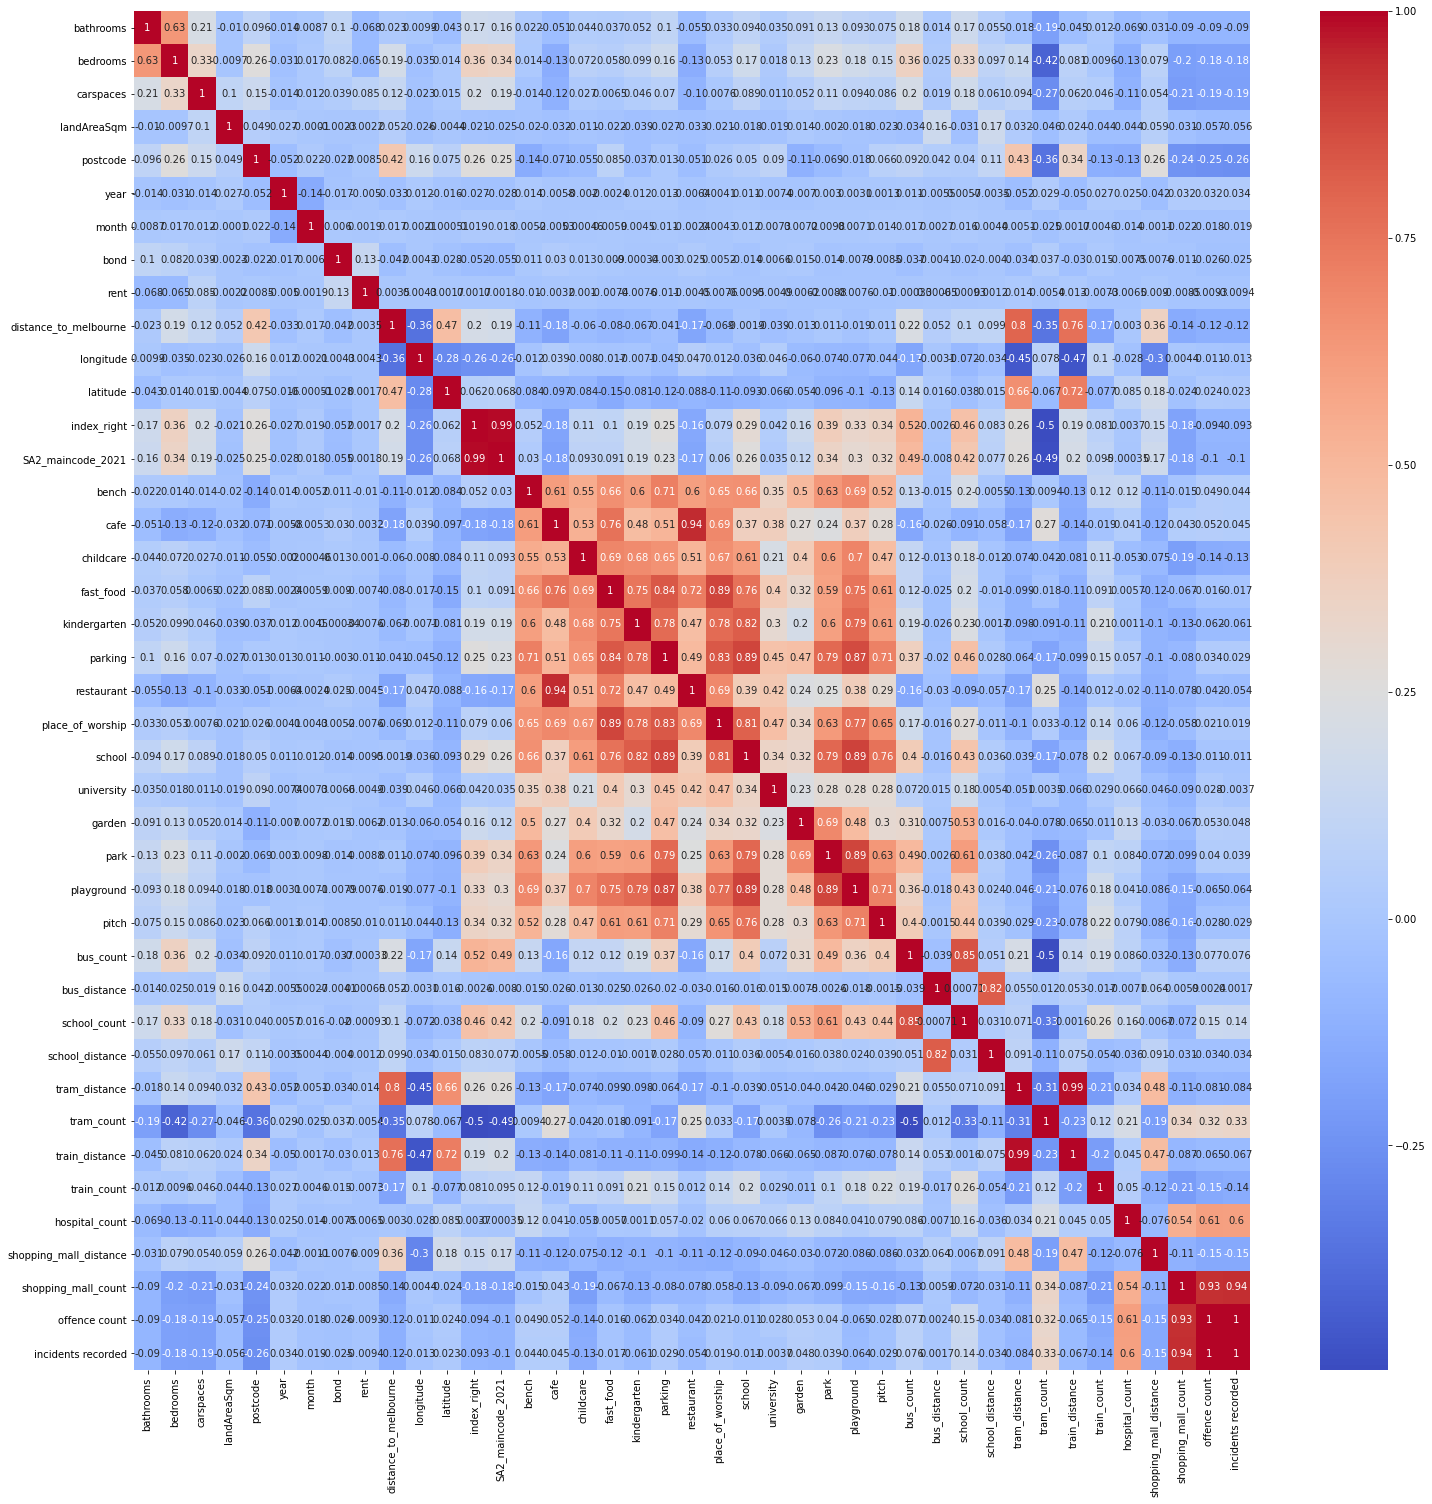

In [821]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(25, 25))
sns.heatmap(house_df_n.corr(), cmap="coolwarm",annot=True)
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

#### 3. ABS Data: Population, income and Sex

##### 3.1 Data Reload

3.1.1 Population

In [822]:
population = pd.read_excel('../data/Population.xlsx', sheet_name="Pop", header=[0,1])
population
house_df2 = house_df_n.merge(population, how="left", left_on=["SA2_maincode_2021"], right_on=[(           'Unnamed: 0_level_0', 'SA2 code')])
house_df2

,propertyTypes,bathrooms,bedrooms,carspaces,dateUpdated,dateListed,geoLocation,landAreaSqm,postcode,surburb,year,month,price,bond,rent,distance_to_melbourne,longitude,latitude,geometry,index_right,SA2_maincode_2021,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch,bus_count,bus_distance,school_count,school_distance,tram_distance,tram_count,train_distance,train_count,hospital_count,shopping_mall_distance,shopping_mall_count,offence count,incidents recorded,"(Unnamed: 0_level_0, SA2 code)","(Unnamed: 1_level_0, SA2 name)","(Population , 2019)","(Population , 2020)","(Population , 2021)","(Population , 2022)","(Population Increase, 2019)","(Population Increase, 2020)","(Population Increase, 2021)","(Population Increase, 2022)"
0,['apartmentUnitFlat'],1.0,1.0,0.0,2019-01-09T00:23:18.123Z,2016-02-16T04:33:49Z,"{""latitude"": -37.8341628, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$360.00 per week,NaN,360.0,2990.7,144.960873,-37.834163,POINT (144.96087 -37.83416),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.375,3,0.577,0.116,24,2.804,0,0,1.388,0,22895,17201,206051512,South Melbourne,12753,12707,11860,11758.973851,0.003541,-0.003607,-0.066656,-0.008518
1,['house'],2.0,2.0,1.0,2019-01-11T17:10:21.69Z,2018-10-24T23:20:07Z,"{""latitude"": -37.8350754, ""longitude"": 144.964...",NaN,3205,south melbourne,2019,1,$725.00 per week,NaN,725.0,3445.0,144.964862,-37.835075,POINT (144.96486 -37.83508),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.730,3,0.299,0.111,24,2.442,0,0,1.714,0,22895,17201,206051512,South Melbourne,12753,12707,11860,11758.973851,0.003541,-0.003607,-0.066656,-0.008518
2,['apartmentUnitFlat'],1.0,2.0,0.0,2019-01-03T02:02:17.513Z,2018-10-25T00:57:25Z,"{""latitude"": -37.8402171, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$500.00 per week,NaN,500.0,4076.1,144.960818,-37.840217,POINT (144.96082 -37.84022),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.766,3,0.579,0.059,24,2.751,0,0,1.927,0,22895,17201,206051512,South Melbourne,12753,12707,11860,11758.973851,0.003541,-0.003607,-0.066656,-0.008518
3,['house'],1.0,3.0,0.0,2019-01-03T17:06:05.923Z,2018-10-25T22:30:15Z,"{""latitude"": -37.8366529, ""longitude"": 144.953...",NaN,3205,south melbourne,2019,1,$795.00 per week,NaN,795.0,3871.4,144.953039,-37.836653,POINT (144.95304 -37.83665),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.209,3,0.165,0.139,24,3.457,0,0,1.304,0,22895,17201,206051512,South Melbourne,12753,12707,11860,11758.973851,0.003541,-0.003607,-0.066656,-0.008518
4,['house'],2.0,2.0,0.0,2019-01-12T17:10:42.533Z,2018-10-31T22:21:33Z,"{""latitude"": -37.8375202, ""longitude"": 144.949...",NaN,3205,south melbourne,2019,1,$825.00 per week,NaN,825.0,3877.5,144.949687,-37.837520,POINT (144.94969 -37.83752),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.143,3,0.475,0.394,24,3.544,0,0,1.370,0,22895,17201,206051512,South Melbourne,12753,12707,11860,11758.973851,0.003541,-0.003607,-0.066656,-0.008518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113161,['house'],1.0,3.0,1.0,2022-05-02T23:02:33.327Z,2022-04-06T22:38:28Z,"{""latitude"": -36.5365807, ""longitude"": 147.493...",NaN,3701,dartmouth,2022,5,$280,NaN,280.0,408332.2,147.493795,-36.536581,POINT (147.49379 -36.53658),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.649,2,10.219,249.694,0,233.799,0,0,68.639,0,302,230,204031072,Towong,6109,6132,6153,6181.185987,0.006094,0.003765,0.003425,0.004581
113162,['house'],1.0,3.0,1.0,2022-06-28T07:34:34.59Z,2022-05-09T04:58:56Z,"{""latitude"": -36.5361943, ""longitude"": 147.494...",NaN,370

In [765]:
# postcode_transform = house_df2[['postcode',('Unnamed: 0_level_0', 'SA2 code')]]
# postcode_transform = postcode_transform.rename({('Unnamed: 0_level_0', 'SA2 code'):'SA2 code'}, axis = 1)
# postcode_transform.to_csv('../data/raw/postcode_transform.csv')

3.1.1 Income

In [699]:
income = pd.read_excel('../data/Income.xlsx',sheet_name="Forecasted Income", header=[0,1]).drop([(           'Unnamed: 0_level_0',      'SA2')], axis = 1)
income[(           'Unnamed: 2_level_0', 'Postcode')] = income[(           'Unnamed: 2_level_0', 'Postcode')].fillna(0)
name_income_dict = dict()
postcode_income_dict = dict()
for index, item in income.iterrows():
    name = item[(           'Unnamed: 1_level_0', 'SA2 NAME')].lower().replace('- ','')
    postcode_income = int(item[(           'Unnamed: 2_level_0', 'Postcode')])
    name_income_dict[name] = item
    postcode_income_dict[postcode_income] = item

def search_income(suburb_name,postcode):
    item = name_income_dict.get(suburb_name)
    if item is not None:
        return item
    item = postcode_income_dict.get(postcode)
    if item is not None:
        return item    
    return None


In [823]:
income_list = []
l = []
col = None
for index, value in house_df2.iterrows():
    item = search_income(value['surburb'], value['postcode'])
    if item is not None:
        l.append(list(item))
        col = item.index
    else:
        l.append([None]*len(col))


In [824]:
income = pd.DataFrame(l, columns=['SA2 NAME','Postcode','Earners_2019','Earners_2020','Earners_2021','Earners_2022','Median_age_2019','Median_age_2020','Median_age_2021','Median_age_2022','sum_2019','sum_2020','sum_2021','sum_2022','median_2019','median_2020','median_2021','median_2022','mean_2019','mean_2020','mean_2021','mean_2022'])
house_original = pd.concat([house_df2, income],axis=1)
# house = house_original.fillna(0)
value_list = []
for index, values in house_original.iterrows():
    year = values['year']
    column_list = list(values.index)[:57]
    for i in list(values.index)[57:]:
        if str(year) in i:
            column_list.append(i)
    new_value = values[column_list]
    value_list.append(list(new_value))
file = pd.DataFrame(value_list, columns = column_list).rename({'Earners_2021':'Earners', 'Median_age_2021':'Median_age', 'sum_2021':'sum', 'median_2021':'median',	'mean_2021':'mean'}, axis = 1)

In [825]:
value_list = []
for index, values in file.iterrows():
    year = values['year']
    column_list = list(values.index)[:48]
    column_list.extend(list(file.columns)[57:])
    for i in list(values.index)[49:57]:
        if i[1] == year:
            column_list.append(i)
    new_value = values[column_list]
    value_list.append(list(new_value))
# file = pd.DataFrame(value_list, columns = column_list).rename({'Earners_2021':'Earners', 'Median_age_2021':'Median_age', 'sum_2021':'sum', 'median_2021':'median',	'mean_2021':'mean'}, axis = 1)

In [826]:
value_list = pd.DataFrame(value_list,columns = column_list)
value_list_2 = value_list.rename({('Population ', 2021):'population'}, axis = 1)
value_list_2 = value_list_2.rename({('Population Increase', 2021):'population_increase'}, axis = 1)
value_list_2

,propertyTypes,bathrooms,bedrooms,carspaces,dateUpdated,dateListed,geoLocation,landAreaSqm,postcode,surburb,year,month,price,bond,rent,distance_to_melbourne,longitude,latitude,geometry,index_right,SA2_maincode_2021,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch,bus_count,bus_distance,school_count,school_distance,tram_distance,tram_count,train_distance,train_count,hospital_count,shopping_mall_distance,shopping_mall_count,offence count,incidents recorded,Earners,Median_age,sum,median,mean,population,population_increase
0,['apartmentUnitFlat'],1.0,1.0,0.0,2019-01-09T00:23:18.123Z,2016-02-16T04:33:49Z,"{""latitude"": -37.8341628, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$360.00 per week,NaN,360.0,2990.7,144.960873,-37.834163,POINT (144.9608734 -37.8341628),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.375,3,0.577,0.116,24,2.804,0,0,1.388,0,22895,17201,9313.509189,38.256757,8.887474e+08,66259.675774,95462.489940,12753.000000,0.003541
1,['house'],2.0,2.0,1.0,2019-01-11T17:10:21.69Z,2018-10-24T23:20:07Z,"{""latitude"": -37.8350754, ""longitude"": 144.964...",NaN,3205,south melbourne,2019,1,$725.00 per week,NaN,725.0,3445.0,144.964862,-37.835075,POINT (144.9648624 -37.8350754),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.730,3,0.299,0.111,24,2.442,0,0,1.714,0,22895,17201,9313.509189,38.256757,8.887474e+08,66259.675774,95462.489940,12753.000000,0.003541
2,['apartmentUnitFlat'],1.0,2.0,0.0,2019-01-03T02:02:17.513Z,2018-10-25T00:57:25Z,"{""latitude"": -37.8402171, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$500.00 per week,NaN,500.0,4076.1,144.960818,-37.840217,POINT (144.9608179 -37.8402171),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.766,3,0.579,0.059,24,2.751,0,0,1.927,0,22895,17201,9313.509189,38.256757,8.887474e+08,66259.675774,95462.489940,12753.000000,0.003541
3,['house'],1.0,3.0,0.0,2019-01-03T17:06:05.923Z,2018-10-25T22:30:15Z,"{""latitude"": -37.8366529, ""longitude"": 144.953...",NaN,3205,south melbourne,2019,1,$795.00 per week,NaN,795.0,3871.4,144.953039,-37.836653,POINT (144.9530393 -37.8366529),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.209,3,0.165,0.139,24,3.457,0,0,1.304,0,22895,17201,9313.509189,38.256757,8.887474e+08,66259.675774,95462.489940,12753.000000,0.003541
4,['house'],2.0,2.0,0.0,2019-01-12T17:10:42.533Z,2018-10-31T22:21:33Z,"{""latitude"": -37.8375202, ""longitude"": 144.949...",NaN,3205,south melbourne,2019,1,$825.00 per week,NaN,825.0,3877.5,144.949687,-37.837520,POINT (144.9496869 -37.8375202),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.143,3,0.475,0.394,24,3.544,0,0,1.370,0,22895,17201,9313.509189,38.256757,8.887474e+08,66259.675774,95462.489940,12753.000000,0.003541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113161,['house'],1.0,3.0,1.0,2022-05-02T23:02:33.327Z,2022-04-06T22:38:28Z,"{""latitude"": -36.5365807, ""longitude"": 147.493...",NaN,3701,dartmouth,2022,5,$280,NaN,280.0,408332.2,147.493795,-36.536581,POINT (147.4937949 -36.5365807),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.649,2,10.219,249.694,0,233.799,0,0,68.639,0,302,230,4963.045082,47.856776,2.293470e+08,44583.025987,45276.629966,6181.185987,NaN
113162,['house'],1.0,3.0,1.0,2022-06-28T07:34:34.59Z,2022-05-09T04:58:56Z,"{""latitude"": -36.5361943, ""longitude"": 147.494...",NaN,3701,dartmouth,2022,6,$290,NaN,290.0,408275.9,147.494529,-36.536194,POINT (147.4945295 -36.5361943),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.627,2,10.283,249.772,0,233.877,0,0,68.662,0,302,230,4963.045082,47.856776,2.293470e+08,44583

In [827]:
value_list_2

,propertyTypes,bathrooms,bedrooms,carspaces,dateUpdated,dateListed,geoLocation,landAreaSqm,postcode,surburb,year,month,price,bond,rent,distance_to_melbourne,longitude,latitude,geometry,index_right,SA2_maincode_2021,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch,bus_count,bus_distance,school_count,school_distance,tram_distance,tram_count,train_distance,train_count,hospital_count,shopping_mall_distance,shopping_mall_count,offence count,incidents recorded,Earners,Median_age,sum,median,mean,population,population_increase
0,['apartmentUnitFlat'],1.0,1.0,0.0,2019-01-09T00:23:18.123Z,2016-02-16T04:33:49Z,"{""latitude"": -37.8341628, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$360.00 per week,NaN,360.0,2990.7,144.960873,-37.834163,POINT (144.9608734 -37.8341628),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.375,3,0.577,0.116,24,2.804,0,0,1.388,0,22895,17201,9313.509189,38.256757,8.887474e+08,66259.675774,95462.489940,12753.000000,0.003541
1,['house'],2.0,2.0,1.0,2019-01-11T17:10:21.69Z,2018-10-24T23:20:07Z,"{""latitude"": -37.8350754, ""longitude"": 144.964...",NaN,3205,south melbourne,2019,1,$725.00 per week,NaN,725.0,3445.0,144.964862,-37.835075,POINT (144.9648624 -37.8350754),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.730,3,0.299,0.111,24,2.442,0,0,1.714,0,22895,17201,9313.509189,38.256757,8.887474e+08,66259.675774,95462.489940,12753.000000,0.003541
2,['apartmentUnitFlat'],1.0,2.0,0.0,2019-01-03T02:02:17.513Z,2018-10-25T00:57:25Z,"{""latitude"": -37.8402171, ""longitude"": 144.960...",NaN,3205,south melbourne,2019,1,$500.00 per week,NaN,500.0,4076.1,144.960818,-37.840217,POINT (144.9608179 -37.8402171),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.766,3,0.579,0.059,24,2.751,0,0,1.927,0,22895,17201,9313.509189,38.256757,8.887474e+08,66259.675774,95462.489940,12753.000000,0.003541
3,['house'],1.0,3.0,0.0,2019-01-03T17:06:05.923Z,2018-10-25T22:30:15Z,"{""latitude"": -37.8366529, ""longitude"": 144.953...",NaN,3205,south melbourne,2019,1,$795.00 per week,NaN,795.0,3871.4,144.953039,-37.836653,POINT (144.9530393 -37.8366529),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.209,3,0.165,0.139,24,3.457,0,0,1.304,0,22895,17201,9313.509189,38.256757,8.887474e+08,66259.675774,95462.489940,12753.000000,0.003541
4,['house'],2.0,2.0,0.0,2019-01-12T17:10:42.533Z,2018-10-31T22:21:33Z,"{""latitude"": -37.8375202, ""longitude"": 144.949...",NaN,3205,south melbourne,2019,1,$825.00 per week,NaN,825.0,3877.5,144.949687,-37.837520,POINT (144.9496869 -37.8375202),790,206051512,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.143,3,0.475,0.394,24,3.544,0,0,1.370,0,22895,17201,9313.509189,38.256757,8.887474e+08,66259.675774,95462.489940,12753.000000,0.003541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113161,['house'],1.0,3.0,1.0,2022-05-02T23:02:33.327Z,2022-04-06T22:38:28Z,"{""latitude"": -36.5365807, ""longitude"": 147.493...",NaN,3701,dartmouth,2022,5,$280,NaN,280.0,408332.2,147.493795,-36.536581,POINT (147.4937949 -36.5365807),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.649,2,10.219,249.694,0,233.799,0,0,68.639,0,302,230,4963.045082,47.856776,2.293470e+08,44583.025987,45276.629966,6181.185987,NaN
113162,['house'],1.0,3.0,1.0,2022-06-28T07:34:34.59Z,2022-05-09T04:58:56Z,"{""latitude"": -36.5361943, ""longitude"": 147.494...",NaN,3701,dartmouth,2022,6,$290,NaN,290.0,408275.9,147.494529,-36.536194,POINT (147.4945295 -36.5361943),718,204031072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,52.627,2,10.283,249.772,0,233.877,0,0,68.662,0,302,230,4963.045082,47.856776,2.293470e+08,44583

In [828]:
value_list_2.to_csv("../data/prepared_data.csv")